In [ ]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pylab
import statsmodels.api as sm
import statsmodels.stats as smt

In [ ]:
url_lol = 'https://raw.githubusercontent.com/michellyrds/mqaa/master/datasets/high_diamond_ranked_10min.csv'

url = url_lol
raw_data = pd.read_csv(url)

raw_data.head(10)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
5,4475365709,1,18,0,0,5,3,6,1,1,0,0,15899,7.0,18161,225,42,698,101,22.5,1589.9,36,5,1,3,5,2,0,0,0,0,15201,7.0,18060,221,59,-698,-101,22.1,1520.1
6,4493010632,1,18,3,1,7,6,7,1,1,0,0,16874,6.8,16967,225,53,2411,1563,22.5,1687.4,57,1,0,6,7,9,0,0,0,0,14463,6.4,15404,164,35,-2411,-1563,16.4,1446.3
7,4496759358,0,16,2,0,5,13,3,0,0,0,0,15305,6.4,16138,209,48,-2615,-800,20.9,1530.5,15,0,1,13,5,11,1,1,0,0,17920,6.6,16938,157,54,2615,800,15.7,1792.0
8,4443048030,0,16,3,0,7,7,8,0,0,0,0,16401,7.2,18527,189,61,-1979,-771,18.9,1640.1,15,2,1,7,7,5,2,1,1,0,18380,7.2,19298,240,53,1979,771,24.0,1838.0
9,4509433346,1,13,1,1,4,5,5,1,1,0,0,15057,6.8,16805,220,39,-1548,-1574,22.0,1505.7,16,2,0,5,4,4,0,0,0,0,16605,6.8,18379,247,43,1548,1574,24.7,1660.5


# Análise de clusters

## Objetivo
**Agrupar objetos com base nas suas similaridades.** Inicialmente, não existe uma estrutura pré-definida de grupos para agrupar os objetos (que são as tuplas do dataset) e a técnica será utilizada para gerar uma descrição taxonômica e identificação de relações. A redução de dados é um objetivo marginal, pois já foi alcançado com a análise de componentes principais.


## Planejamento da análise de clusters

- Similadaridade de objetos: usaremos a distância euclidiana;
- Tratamento de observações atípicas: outliers fortemente influentes do dataset serão removidos;
<!--- , com exceção das variáveis dicotômicas: _blueWins_ e _blueFirstBlood_: --->
- Tamanho da amostra: inicialmente, 9876 linhas. Como o número máximo de clusters utilizado no presente trabalho é menor que 10, o tamanho da amostra é suficiente. 
- Dado a discrepância de alguns dados (como a variável **blueGoldDiff**), os dados serão padronizados com o método range entre 0 e 1. 

In [ ]:
df = raw_data.filter(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin'])
df.info

<bound method DataFrame.info of       blueWins  blueWardsPlaced  ...  blueCSPerMin  blueGoldPerMin
0            0               28  ...          19.5          1721.0
1            0               12  ...          17.4          1471.2
2            0               15  ...          18.6          1611.3
3            0               43  ...          20.1          1515.7
4            0               75  ...          21.0          1640.0
...        ...              ...  ...           ...             ...
9874         1               17  ...          21.1          1776.5
9875         1               54  ...          23.3          1623.8
9876         0               23  ...          21.0          1590.3
9877         0               14  ...          22.4          1445.9
9878         1               18  ...          20.7          1626.6

[9879 rows x 20 columns]>

Identificando todos outliers mais influentes do dataset:

In [ ]:
# Use GLM method for logreg here so that we can retrieve the influence measures
X, y = df.loc[:, df.columns!='blueWins'], df.filter(['blueWins'], axis=1) 

logit_results = sm.GLM(y, X, family=sm.families.Binomial()).fit()

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[['cooks_d']]

# Set Cook's distance threshold
cook_threshold = 4 / len(df)

# Append absolute standardized residual values 
diagnosis_df['std_resid'] = st.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]

# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False).head()

print("Número de outliers fortemente influentes: {}".format(len(extreme)))

Número de outliers fortemente influentes: 56


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
extreme.head(5)

,cooks_d,std_resid
106,0.000508,4.644565
376,0.000864,3.242720
878,0.000551,3.203014
1194,0.001588,4.157358
1342,0.000446,3.728460


## Suposições
- Representatividade da amostra: como não controlamos o processo de anotação das variáveis, estamos supondo que as mesmas são representativas;
- Multicolinearidade entre variáveis na variável estatística de agrupamento


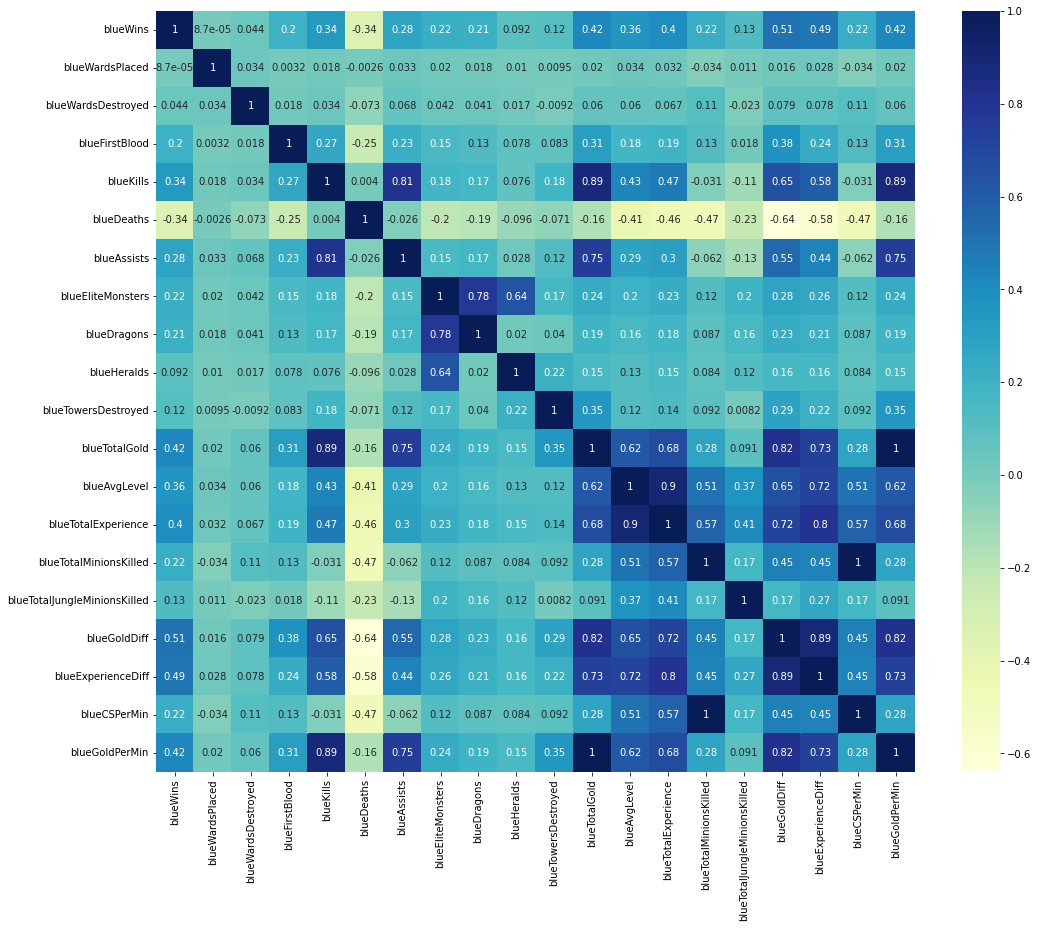

In [ ]:
fig = plt.figure(figsize=(17,14))
dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
  
plt.show()

Iremos remover as variáveis com alto índice de correlação a fim de diminuir o efeito de ponderação da multicolinearidade na análise:

In [ ]:
df = raw_data.filter(['blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin'])

df = df.drop(labels=['blueAvgLevel', 'blueTotalGold', 'blueGoldPerMin', 'blueCSPerMin', 'blueExperienceDiff'], axis=1)

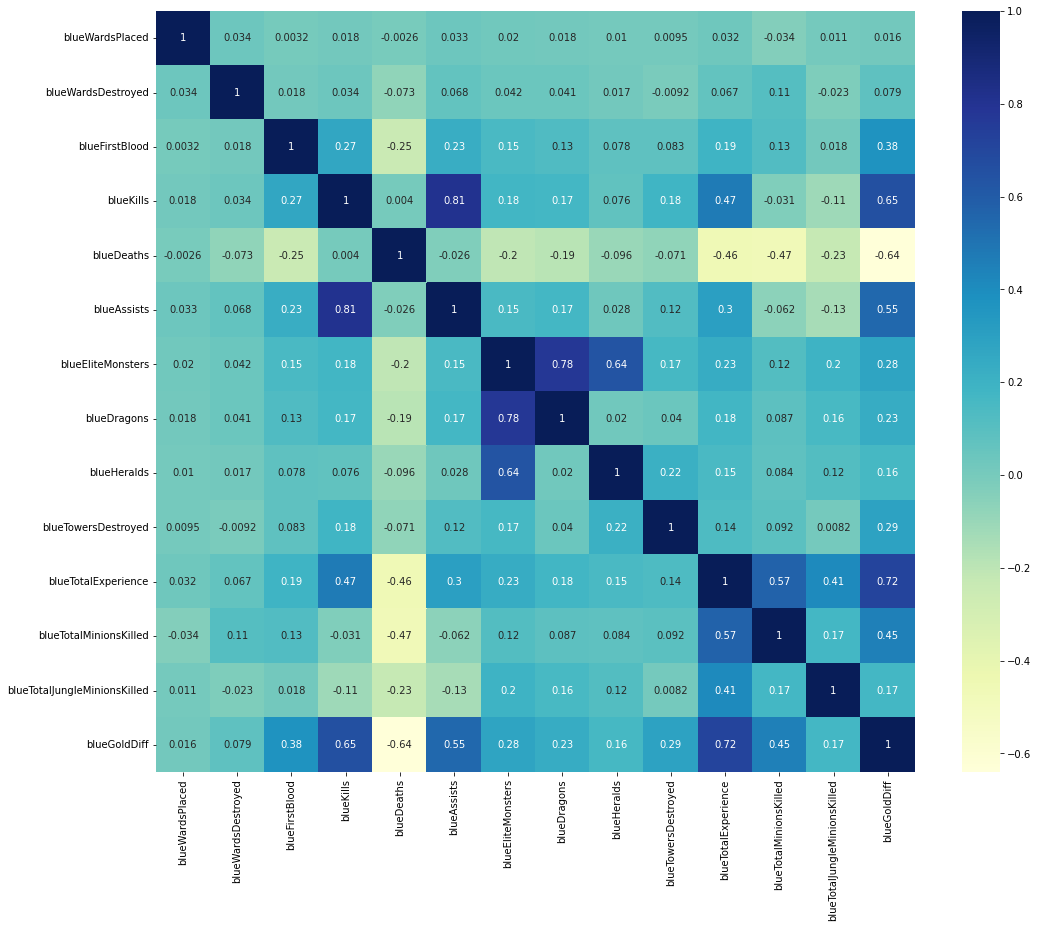

In [ ]:
fig = plt.figure(figsize=(17,14))
dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
  
plt.show()

Além disso, podemos verificar o efeito da multicolinearidade com o VIF:

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return(vif)

calc_vif(df)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,blueWardsPlaced,2.553855
1,blueWardsDestroyed,2.753687
2,blueFirstBlood,2.348582
3,blueKills,43.569207
4,blueDeaths,22.316223
5,blueAssists,11.092730
6,blueEliteMonsters,inf
7,blueDragons,inf
8,blueHeralds,inf
9,blueTowersDestroyed,1.268578


## Determinação de agrupamentos

Preparação do dataset para aplicação das técnicas: 
- Remoção de variáveis com alto índice de multicolinearidade;
- Remoção de outliers influentes;
- Padronização do dataset - método range;
- _Holdout_ do dataset: separação em conjunto de treino e teste.

In [ ]:
from sklearn.model_selection import train_test_split

df = raw_data.filter(['blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin'])

df = df.drop(labels=['blueAvgLevel', 'blueTotalGold', 'blueGoldPerMin', 'blueCSPerMin', 'blueExperienceDiff'], axis=1)

df = df.drop(diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)].index)


normalized_df = (df - df.min())/(df.max()-df.min())

X, y = normalized_df.loc[:, normalized_df.columns!='blueWins'], normalized_df.filter(['blueWins'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
df.info

<bound method DataFrame.info of       blueWardsPlaced  ...  blueGoldDiff
0                  28  ...           643
1                  12  ...         -2908
2                  15  ...         -1172
3                  43  ...         -1321
4                  75  ...         -1004
...               ...  ...           ...
9874               17  ...          2519
9875               54  ...           782
9876               23  ...         -2416
9877               14  ...          -839
9878               18  ...           927

[9823 rows x 14 columns]>

### Escolhendo o número apropriado de clusters

Usaremos o método de elbow e o coeficiente de silhueta: 

Text(0, 0.5, 'Inertia')

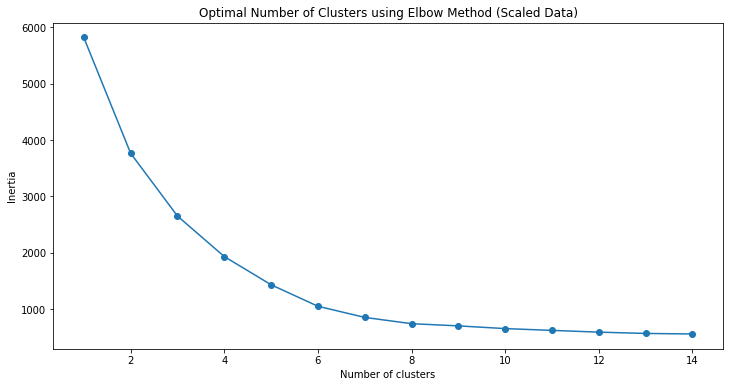

In [ ]:
from sklearn.cluster import KMeans

sse = []
sse_kl = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(X_train)
    sse.append([k, km.inertia_])
    sse_kl.append(km.inertia_)
    
oca_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

Identificando o ponto de inflexão:

In [ ]:
!pip install kneed

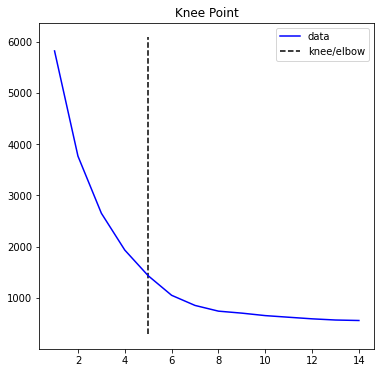

In [ ]:
from kneed import KneeLocator, DataGenerator as dg

kl = KneeLocator(
    range(1, 15), sse_kl, curve="convex", direction="decreasing"
) 

kl.plot_knee()

### Coeficiente de silhueta



In [ ]:
from sklearn.metrics import silhouette_score

kmeans_args = {
  "init": 'k-means++',
  "n_init": 100,
  "max_iter": 400,
  "random_state": 42,
}

silhouette_coefficients = []
for k in range(2, 15):
  kmeans = KMeans(n_clusters=k, **kmeans_args)
  kmeans.fit(X_train)
  score = silhouette_score(X_train, kmeans.labels_)
  silhouette_coefficients.append(score)

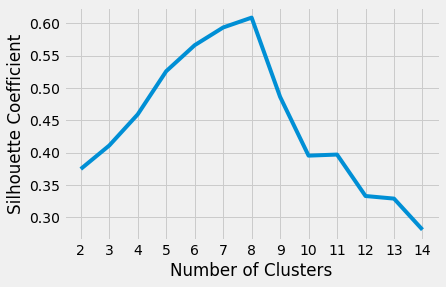

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 15), silhouette_coefficients)
plt.xticks(range(2, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [ ]:
kmeans_scale = KMeans(n_clusters=8, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(X_train)
print('KMeans Scaled Silhouette Score: {}'.format(silhouette_score(X_train, kmeans_scale.labels_, metric='euclidean')))
labels_scale = kmeans_scale.labels_
clusters_scale = pd.concat([X_train, pd.DataFrame({'cluster_scaled':labels_scale})], axis=1)

KMeans Scaled Silhouette Score: 0.6085145729858971


Apesar do teste de Elbow ter indicado que um número ótimo de agrupamentos seria 5, vamos optar por 8, pois foi o que obteve o maior score no coeficiente de silhueta.

## Aplicando as técnicas de _clustering_

Executaremos a análise de agrupamentos, utilizando as técnicas:
 - Agrupamento hierárquico aglomerativo: com o método de Ward;
 - não-hierárquico: _k-means clustering_.

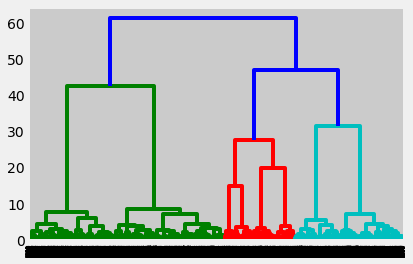

In [ ]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(X_train, method='ward'))
hc = AgglomerativeClustering(n_clusters=8, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X_train)

Executando o K-Means: 

In [ ]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=8)
model.fit(X_train)
print("Centroides dos clusters:\n{}".format(model.cluster_centers_))


Centroides dos clusters:
[[ 6.84458399e-02  1.03194620e-01  1.00000000e+00  2.94250831e-01
   2.69660667e-01  2.40031308e-01 -4.49640325e-15 -5.55111512e-17
  -1.77635684e-15  6.14754098e-03  6.44089883e-01  6.62052676e-01
   5.29819343e-01  5.01927153e-01]
 [ 7.40732847e-02  1.10111852e-01  1.00000000e+00  3.36498141e-01
   2.28894691e-01  2.84835389e-01  5.00000000e-01  1.00000000e+00
  -2.38697950e-15  1.37075718e-02  6.71372047e-01  6.70698106e-01
   5.61821243e-01  5.41968691e-01]
 [ 7.10143463e-02  1.00146681e-01 -8.65973959e-15  2.28465347e-01
   3.30175518e-01  1.81819734e-01 -4.94049246e-15 -4.49640325e-15
   2.22044605e-16  2.59900990e-03  6.09821380e-01  6.30959832e-01
   5.31231167e-01  4.24228562e-01]
 [ 7.27097906e-02  1.08973520e-01 -3.99680289e-15  2.64910590e-01
   2.80490417e-01  2.21436985e-01  5.00000000e-01  1.00000000e+00
  -8.60422844e-16  5.30035336e-03  6.46557922e-01  6.58104323e-01
   5.66126389e-01  4.69538994e-01]
 [ 7.13973663e-02  1.10431532e-01  1.000000

In [ ]:
labels = model.predict(X_test)

print("Resultado do agrupamento:\n{}".format(labels))

Resultado do agrupamento:
[0 5 2 ... 3 2 3]


Tabela com as tuplas de testes e com o index de seu cluster:

In [ ]:
X_test['cluster'] = labels

X_test.head()


,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,cluster
9288,0.089796,0.074074,1.0,0.136364,0.272727,0.137931,0.0,0.0,0.0,0.0,0.649184,0.642487,0.695652,0.452079,0
9156,0.036735,0.074074,1.0,0.181818,0.318182,0.206897,0.5,0.0,1.0,0.0,0.538100,0.621762,0.565217,0.439028,5
353,0.069388,0.074074,0.0,0.272727,0.136364,0.344828,0.0,0.0,0.0,0.0,0.745835,0.735751,0.586957,0.592367,2
2206,0.330612,0.111111,0.0,0.181818,0.227273,0.137931,0.0,0.0,0.0,0.0,0.586921,0.709845,0.500000,0.455398,2
3813,0.032653,0.074074,0.0,0.090909,0.409091,0.034483,0.0,0.0,0.0,0.0,0.332426,0.388601,0.565217,0.327174,2


## Avaliação do ajuste geral

Reduzindo a dimensionalidade com PCA do resultado da análise de agrupamentos k-means para a visualização do ajuste geral:

KMeans Scaled Silhouette Score: 0.6075029443750367


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



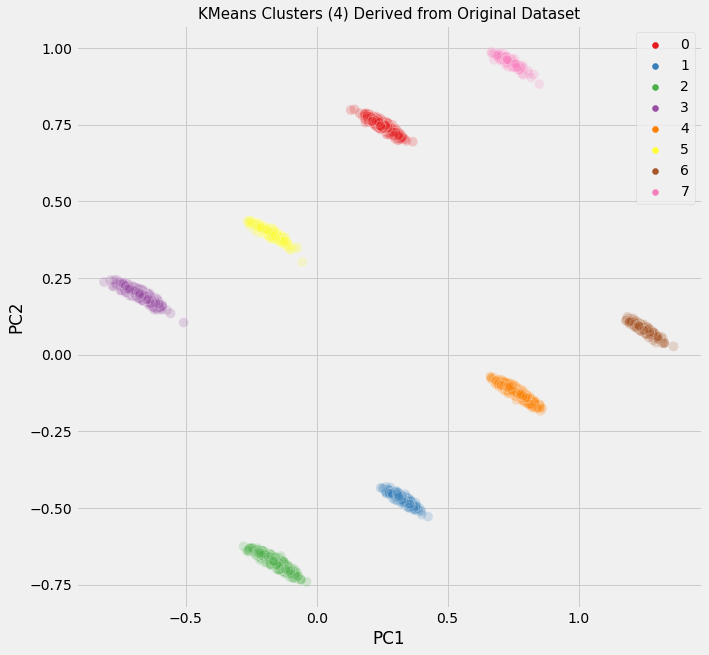

In [ ]:
from sklearn.decomposition import PCA

kmeans_scale = KMeans(n_clusters=8, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(X_train)
print('KMeans Scaled Silhouette Score: {}'.format(silhouette_score(X_train, kmeans_scale.labels_, metric='euclidean')))
labels_scale = kmeans_scale.labels_
clusters_scale = pd.concat([X_train, pd.DataFrame({'cluster_scaled':labels_scale})], axis=1)

pca2 = PCA(n_components=8).fit(X_train)
pca2d = pca2.transform(X_train)
plt.figure(figsize = (10,10))
sb.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=labels_scale, 
                palette='Set1',
                s=100, alpha=0.2).set_title('KMeans Clusters (4) Derived from Original Dataset', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

Plot 3D dos agrupamentos:

In [ ]:
from plotly.graph_objects import Scatter3d, Figure, Layout

Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
labels = labels_scale
trace = Scatter3d(x=pca2d[:,0], y=pca2d[:,1], z=pca2d[:,2], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'gray',width = 5)))
layout = Layout(margin=dict(l=0,r=0),scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = Figure(data = data, layout = layout)
fig.show()

## Interpretação dos agrupamentos

Como podemos ver nos plots, os conjuntos ficaram bem agrupados e densos entorno dos centróides. Também podemos observar que cada agrupamento está bem definido e distante dos outros, possívelmente por conta da presença de variáveis discreta na utilizada na nossa amostra.

## Validação e perfil dos agrupamentos

In [ ]:
#print(X_test)

df_fa = pd.DataFrame(kmeans_scale.cluster_centers_,index=['c0','c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7'],columns=['blueWardsPlaced',	'blueWardsDestroyed',	'blueFirstBlood',	'blueKills',	'blueDeaths',	'blueAssists',	'blueEliteMonsters',	'blueDragons',	'blueHeralds',	'blueTowersDestroyed',	'blueTotalExperience',	'blueTotalMinionsKilled',	'blueTotalJungleMinionsKilled',	'blueGoldDiff'])

decimals = 3    
dfround = df_fa.apply(lambda x: round(x, decimals))

#df_fa.head(7)
dfround.head(8)


,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff
c0,0.073,0.109,-0.0,0.265,0.280,0.221,0.5,1.0,-0.0,0.005,0.647,0.658,0.566,0.470
c1,0.068,0.103,1.0,0.294,0.270,0.240,-0.0,-0.0,-0.0,0.006,0.644,0.662,0.530,0.502
c2,0.074,0.110,1.0,0.336,0.229,0.285,0.5,1.0,-0.0,0.014,0.671,0.671,0.562,0.542
c3,0.071,0.100,-0.0,0.228,0.330,0.182,-0.0,-0.0,0.0,0.003,0.610,0.631,0.531,0.424
c4,0.077,0.110,1.0,0.315,0.239,0.249,0.5,-0.0,1.0,0.045,0.679,0.682,0.556,0.539
c5,0.076,0.105,0.0,0.291,0.271,0.231,1.0,1.0,1.0,0.029,0.677,0.669,0.612,0.501
c6,0.065,0.112,0.0,0.250,0.300,0.190,0.5,0.0,1.0,0.032,0.648,0.655,0.568,0.470
c7,0.071,0.110,1.0,0.346,0.205,0.273,1.0,1.0,1.0,0.046,0.706,0.696,0.594,0.573


Os clusters foram agrupados baseando-se fortemente nas variáveis blueFirstBlood, blueDragons e blueHeralds. As outras variáveis obtiveram valores muito similares entre si, o que impediu de ter uma interpretação sobre o impacto dessas variáveis.

O agrupamento se deu da seguinte forma:
- cluster 0: não obteve nada
- cluster 1: obteve apenas o first blood
- cluster 2: obteve apenas o dragon
- cluster 3: obteve o first blood e abateu o dragon
- cluster 4: obteve os 3 fatores 
- cluster 5: abateu o herald e dragon
- cluster 6: abateu apenas o herald
- cluster 7: obteve o first blood e abateu o herald

## Referências

**K-Means Clustering in Python: A Practical Guide.** Disponível em: https://realpython.com/k-means-clustering-python/


---

**An Introduction to Clustering Algorithms in Python.** Disponível em: https://towardsdatascience.com/an-introduction-to-clustering-algorithms-in-python-123438574097


---
**Explaining K-Means Clustering**. Disponível em: https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6



---

**KMeans Silhouette Score Explained With Python Example.** Disponível em: https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam
